In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import datetime

device = torch.device("cuda:0")

path = "./车辆分类数据集/bus/bus001.jpg"
train_features = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
test_features = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)

# 处理客车数据，总共218张，前153张为训练集，后65张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/bus/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/bus/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 153:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

# 处理汽车数据，总共779张，前545张为训练集，后234张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/car/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/car/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 545:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

# 处理货车数据，总共360张，前252张为训练集，后108张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/truck/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/truck/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 252:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

train_features = train_features.permute(0,3,2,1)
test_features = test_features.permute(0,3,2,1)
print(train_features.shape)
print(test_features.shape)

# =================== 训练集标签 =================== #
train_labels = torch.zeros(154).long()
train_labels = torch.cat((train_labels,torch.ones(545).long()), dim=0)
train_labels = torch.cat((train_labels,torch.ones(252).long()+1), dim=0)
print(train_labels.shape)

# =================== 测试集标签 =================== #
test_labels = torch.zeros(66).long()
test_labels = torch.cat((test_labels,torch.ones(234).long()), dim=0)
test_labels = torch.cat((test_labels,torch.ones(108).long()+1), dim=0)
print(test_labels.shape)

torch.Size([951, 3, 100, 100])
torch.Size([408, 3, 100, 100])
torch.Size([951])
torch.Size([408])


In [9]:
# ========================= 定义模型 ========================= #

class ConvModule(torch.nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        #定义一个一层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)           
        )
        self.fc = nn.Linear(32, num_classes) #[32,3] ,32是卷积输出的通道数，out_channels是多少这里就是多少
 
    def forward(self, X):
        #X = X.requires_grad_()
        out = self.conv(X)
        #print(out.shape)  #torch.Size([32, 32, 98, 98])
        out = nn.functional.avg_pool2d(out, 98)
        #print(out.shape) #torch.Size([32, 32, 1, 1])
        out = out.squeeze()
        #print(out.shape) #torch.Size([32, 32])
        out = self.fc(out)
        return out

In [10]:
#训练函数
def train_epoch(net, data_loader, device):
    
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

#测试函数
def test_epoch(net, data_loader, device):
    
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [6]:
num_classes = 3
num_epoch = 100
lr = 0.001
batch_size = 128

#划分数据集
train_dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
test_dataset = torch.utils.data.TensorDataset(test_features,test_labels)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

net = ConvModule().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_sum = []
train_acc_sum = []
test_loss_sum = []
test_acc_sum = []

for epoch in range(num_epoch):
    
    train_loss, train_acc = train_epoch(net, train_iter, device)
    test_loss, test_acc = test_epoch(net, test_iter, device)
    
    train_loss_sum.append(train_loss)
    train_acc_sum.append(train_acc)
    test_loss_sum.append(test_loss)
    test_acc_sum.append(test_acc)
    
    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f' % 
          (epoch+1, train_loss, test_loss, train_acc, test_acc))

epoch 1, train_loss 1.041964, test_loss 1.086847, train_acc 0.550999, test_acc 0.426471
epoch 2, train_loss 0.981382, test_loss 1.047078, train_acc 0.588854, test_acc 0.610294
epoch 3, train_loss 0.947494, test_loss 1.000940, train_acc 0.582545, test_acc 0.573529
epoch 4, train_loss 0.928414, test_loss 0.957754, train_acc 0.583596, test_acc 0.571078
epoch 5, train_loss 0.897634, test_loss 0.923764, train_acc 0.587802, test_acc 0.571078
epoch 6, train_loss 0.880087, test_loss 0.863691, train_acc 0.587802, test_acc 0.580882
epoch 7, train_loss 0.870254, test_loss 0.847584, train_acc 0.593060, test_acc 0.602941
epoch 8, train_loss 0.851421, test_loss 0.880510, train_acc 0.603575, test_acc 0.605392
epoch 9, train_loss 0.842107, test_loss 0.846486, train_acc 0.614090, test_acc 0.632353
epoch 10, train_loss 0.828821, test_loss 0.787264, train_acc 0.621451, test_acc 0.637255
epoch 11, train_loss 0.814769, test_loss 0.828771, train_acc 0.631966, test_acc 0.615196
epoch 12, train_loss 0.813360,

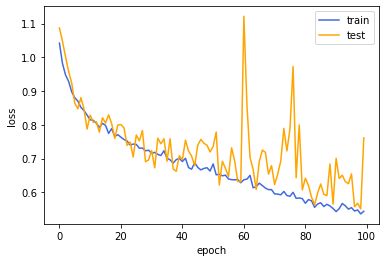

In [7]:
plt.plot(train_loss_sum ,label='train',color='royalblue')
plt.plot(test_loss_sum ,label='test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

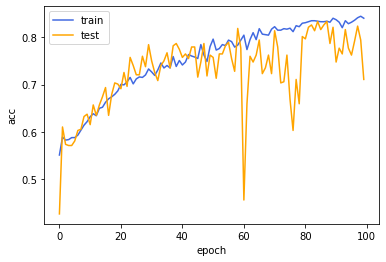

In [8]:
plt.plot(train_acc_sum ,label='train',color='royalblue')
plt.plot(test_acc_sum ,label='test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend()
plt.show()